In [ ]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import torch
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Set GPU
device = torch.device("cuda")

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("sentiment140")

In [ ]:
train = pd.DataFrame.from_dict(dataset['train'])

In [ ]:
train = train.drop(columns=['user', 'date', 'query'])

In [ ]:
print(train.head())

                                                text  sentiment
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0
1  is upset that he can't update his Facebook by ...          0
2  @Kenichan I dived many times for the ball. Man...          0
3    my whole body feels itchy and like its on fire           0
4  @nationwideclass no, it's not behaving at all....          0


In [ ]:
print(train.shape)

(1600000, 2)


In [ ]:
def text_cleaning(text):
	soup = BeautifulSoup(text, "html.parser")
	text = re.sub(r'\[[^]]*\]', '', soup.get_text())
	pattern = r"[^a-zA-Z0-9\s,']"
	text = re.sub(pattern, '', text)
	return text


In [ ]:
# Function to convert score to sentiment
def to_sentiment(rating):

    rating = int(rating)

    # Convert to class
    if rating < 2:
        return 0
    else:
        return 2


# Apply to the dataset
train['sentiment'] = train.sentiment.apply(to_sentiment)

In [ ]:
train_df, test_df = train_test_split(train, test_size=0.3, random_state=42)

In [ ]:
print(sentiment_counts)

In [ ]:
sentiment_counts = train_df['sentiment'].value_counts()

fig =px.bar(x= {0:'Negative', 1: 'Neutral', 2:'Positive'},
			y= sentiment_counts.values,
			color=sentiment_counts.index,
			color_discrete_sequence = px.colors.qualitative.Dark24,
			title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
				xaxis_title='Sentiment',
				yaxis_title='Counts',
				template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)


'Sentiments Counts.html'

In [ ]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['text'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['text'].apply(text_cleaning).tolist()


<ipython-input-10-2374454d2258>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-10-2374454d2258>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [ ]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=800,
						height=400,
						stopwords=set(STOPWORDS),
						background_color='black').generate(all_text)
	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()


In [ ]:
print(train_df.head())

                                                      text  sentiment  \
1064291  Disnleyland ISN'T tha happiest place in tha wo...          1   
281802   OMG BELLLLYYY SHOUTIN AT SUM FOOD.. BRB SOOOO ...          0   
168792   I'm still waiting to find out what #caca stand...          0   
911020                                     So's your face           1   
69604      So sad to see her drive away  wat do i do now??          0   

                                          Cleaned_sentence  
1064291  Disnleyland ISN'T tha happiest place in tha wo...  
281802   OMG BELLLLYYY SHOUTIN AT SUM FOOD BRB SOOOO ST...  
168792   I'm still waiting to find out what caca stands...  
911020                                     So's your face   
69604        So sad to see her drive away  wat do i do now  


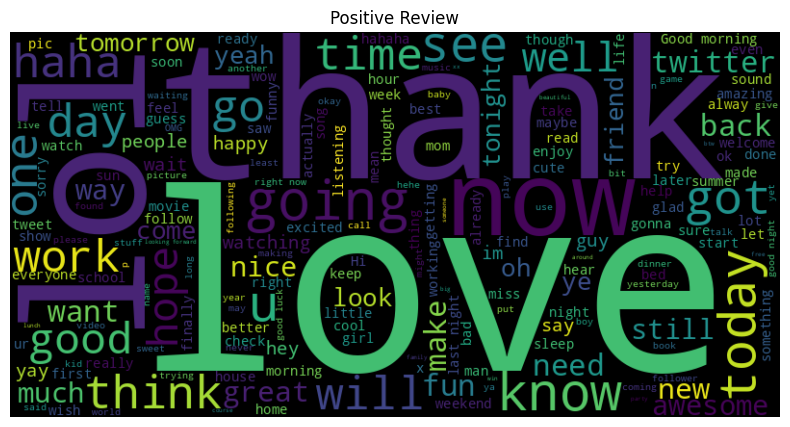

In [ ]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')


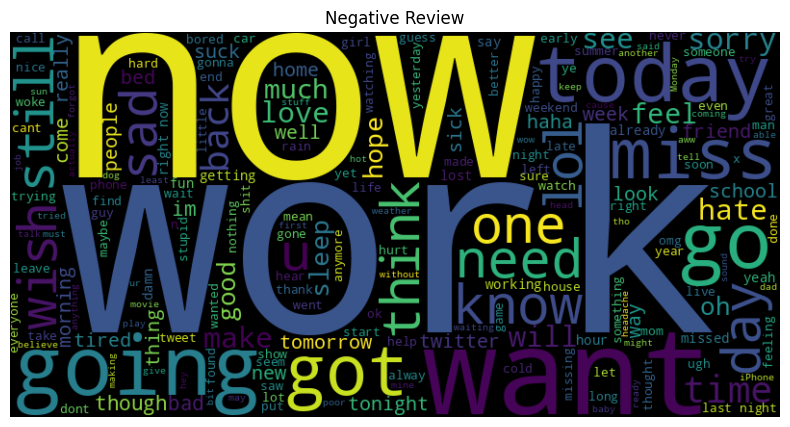

In [ ]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')


In [ ]:
print(test_df.head(30))

                                                      text  sentiment  \
541200              @chrishasboobs AHHH I HOPE YOUR OK!!!           0   
750      @misstoriblack cool , i have no tweet apps  fo...          0   
766711   @TiannaChaos i know  just family drama. its la...          0   
285055   School email won't open  and I have geography ...          0   
705995                              upper airways problem           0   
379611          Going to miss Pastor's sermon on Faith...           0   
1189018            on lunch....dj should come eat with me           1   
667030    @piginthepoke oh why are you feeling like that?           0   
93541      gahh noo!peyton needs to live!this is horrible           0   
1097326  @mrstessyman thank you glad you like it! There...          1   
1380171  @PerezHilton Zach makes me pee sitting down! A...          1   
1233933  to sum up my day in one word ......... kackered!           1   
1495501                    @k9wkj Great minds think

In [ ]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews = "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']


In [ ]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
													test_targets,
													test_size=0.5,
													stratify = test_targets)


In [ ]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [ ]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')


In [ ]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])


Training Comments -->> switchfoot httptwitpiccom2y1zl  Awww, that's a bummer  You shoulda got David Carr of Third Day to do it D

Input Ids -->>
 tf.Tensor(
[  101  4487  2015 20554  3240  3122  3475  1005  1056 22794  5292  9397
 10458  2173  1999 22794  2088 24665  4215  4440  2064 11891  2026 10338
  1010  2092  2672  2025  3894  3137  2049  1037  2235  2088  4536   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(76,), dtype=int32)

Decoded Ids -->>
 [CLS] disnleyland isn't tha happiest place in tha world grad trip can suck my cock, well maybe not magic mountain its a small world ride [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [ ]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [ ]:
# Step 5: Train the model
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	Target,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
	batch_size=32,
	epochs=3
)


Epoch 1/3
35000/35000 [==============================] - 18874s 538ms/step - loss: 0.3501 - accuracy: 0.8456 - val_loss: 0.3230 - val_accuracy: 0.8593
Epoch 2/3
35000/35000 [==============================] - 18829s 538ms/step - loss: 0.2906 - accuracy: 0.8761 - val_loss: 0.3221 - val_accuracy: 0.8607
Epoch 3/3
35000/35000 [==============================] - 18798s 537ms/step - loss: 0.2388 - accuracy: 0.9017 - val_loss: 0.3402 - val_accuracy: 0.8602


In [ ]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


7500/7500 [==============================] - 1277s 170ms/step - loss: 0.3410 - accuracy: 0.8594
Test loss: 0.34104079008102417, Test accuracy: 0.8593666553497314


In [ ]:
model_save_name = 'Model_TweetSentimentClassifier_3Class'
path = F"/content/gdrive/MyDrive/Colab Notebooks/NLP_ClassProject/3Class"
model.save_weights(os.path.join(path, model_save_name))

In [ ]:
print(model.summary)

<bound method Model.summary of <transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification object at 0x787af00b58a0>>
